### Importing modules

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import sklearn

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


### Loading the data

In [3]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
# Make a dataframe
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

# Set how many rows are set in the dataframe
pd.set_option('display.min_rows', 10) 
pd.set_option('display.max_rows', 10) 

# Show the dataframe
display(train_df)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


### Histogram plots of male and female survival rates for different ages

Text(0, 0.5, 'Number of people')

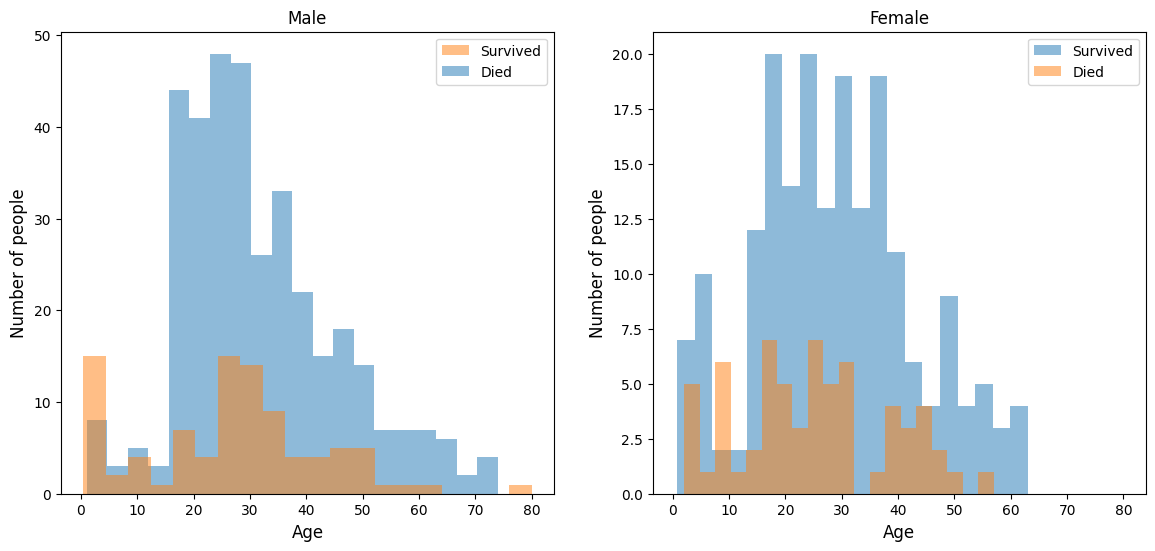

In [4]:
male_train_df = train_df.loc[train_df['Sex'] == 'male']
female_train_df = train_df.loc[train_df['Sex'] == 'female']

male_survived_df = male_train_df.loc[male_train_df['Survived'] == 1]
male_died_df = male_train_df.loc[male_train_df['Survived'] == 0]

female_survived_df = female_train_df.loc[female_train_df['Survived'] == 1]
female_died_df = female_train_df.loc[female_train_df['Survived'] == 0]


fig, (ax0,ax1) = plt.subplots(nrows=1, ncols=2, figsize=(14,6), sharex=True)

histogram_male_survived = ax0.hist(male_survived_df['Age'], bins=20, alpha=0.5,  label='Survived', color='C1', zorder=1);
histogram_male_died = ax0.hist(male_died_df['Age'], bins=20, alpha=0.5,  label='Died', color='C0', zorder=0);

histogram_female_survived = ax1.hist(female_survived_df['Age'], bins=20, alpha=0.5,  label='Survived');
histogram_female_died = ax1.hist(female_died_df['Age'], bins=20, alpha=0.5,  label='Died');

# Add a legend to ax0
ax0.legend()
ax1.legend()

ax0.set(title='Male', xlabel='Age', ylabel='Number of people');
ax1.set(title='Female', xlabel='Age', ylabel='Number of people');

ax0.set_xlabel('Age', fontsize = 12)
ax0.set_ylabel('Number of people', fontsize = 12)
ax1.set_xlabel('Age', fontsize = 12)
ax1.set_ylabel('Number of people', fontsize = 12)

Text(0, 0.5, 'Number of people')

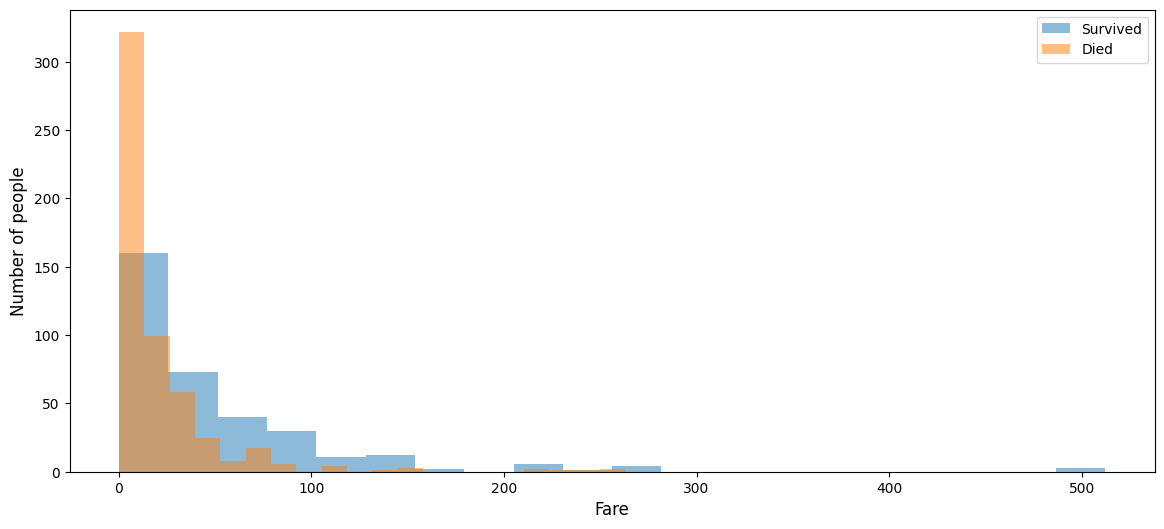

In [5]:
# Plot histograms of the Number who survived/died according to fare price
survived_df = train_df.loc[train_df['Survived'] == 1]
died_df = train_df.loc[train_df['Survived'] == 0]

fig, ax = plt.subplots(figsize=(14,6))

survived_hist = ax.hist(survived_df['Fare'], bins=20, alpha=0.5,  label='Survived', color='C0', zorder=0);
died_ = ax.hist(died_df['Fare'], bins=20, alpha=0.5,  label='Died', color='C1', zorder=1);

# Add a legend to ax0
ax.legend()

ax.set_xlabel('Fare', fontsize = 12)
ax.set_ylabel('Number of people', fontsize = 12)

In [6]:
import re 

# New data frame to work with
new_train_df = train_df.copy(deep=True)

# Function to create a new column with the title of each passenger
new_train_df['Title'] = new_train_df['Name'].map(lambda x: re.compile(", (.*?)\.").findall(x)[0])

# Allocate uncommon titles to broader title categories
def replace_titles(x):
    title=x['Title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col', 'Sir']:
        return 'Mr'
    elif title in ['the Countess', 'Mme', 'Lady', 'Dona']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title

deck = {"A": "A", "B": "B", "C": "C", "D": "D", "E": "E", "F": "F", "G": "G", "U": "U"}

# Function to replace the cabin code with their deck section, denoted by a letter
def replace_cabin(x):
    x['Cabin'] = x['Cabin'].fillna("U0")
    x['Deck'] = x['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    x['Deck'] = x['Deck'].map(deck)
    x['Deck'] = x['Deck'].fillna("U")
    x.drop('Cabin',axis=1, inplace=True)
    
    return x

# Show the new altered dataframes with 'Title' and 'Deck' columns
new_train_df['Title']=new_train_df.apply(replace_titles, axis=1)
new_train_df= replace_cabin(new_train_df)

new_train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,Deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr,U
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss,U
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mrs,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Mr,U
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S,Mr,U
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S,Miss,B
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,S,Miss,U
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C,Mr,C


In [92]:
# Import the methods for pipeline processing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer

# Function to take a dataframe and prepare it for training. It imputes (fills missing values) for"Age" and "Fare", 
# makes the "Cabin" and "Sex" column binary (i.e in a cabin or not, male or female) and one hot encodes the "Embarked",
# "Title" and "Deck" column. 

def prepare_dataframe(df, drop_columns):
    # Copying dataframe to manipulate
    new_df = df.copy(deep=True)
    
    # Binary mapping the sex column
    binary_mapping = {"male" : 0, "female": 1}
    new_df["Sex"] = new_df["Sex"].map(binary_mapping)
    
    # Creating the new Title and Deck columns
    new_df['Title'] = new_df['Name'].map(lambda x: re.compile(", (.*?)\.").findall(x)[0])
    new_df['Title'] = new_df.apply(replace_titles, axis=1)
    
    new_df = replace_cabin(new_df)
    
    # Numeric and categorical features to encode
    numeric_features = ["Fare"]
    categorical_features = ["Embarked", "Title", "Deck"]
    
    # Strategies for transforming these features
    numeric_transformer = Pipeline(steps = [("imputer", SimpleImputer(strategy="mean"))])
    
    categorical_transformer = Pipeline(steps = [ ("imputer", SimpleImputer(strategy = "constant", 
                                                                           fill_value="missing")),
                                               ("onehot", OneHotEncoder(handle_unknown="ignore"))])
    # Transforming these features    
    preprocessor = ColumnTransformer(transformers = [("num", numeric_transformer, numeric_features),
                                                    ("cat", categorical_transformer, categorical_features)])
    
    preprocessor.fit(new_df)
    
    transformed_data = preprocessor.transform(new_df)
    
    # Getting transformed data and creating new columns to put them in 
    numeric_data = transformed_data[:, :len(numeric_features)].toarray()
    categorical_data = transformed_data[:, len(numeric_features):].toarray()
        
    categorical_encoded_features = preprocessor.named_transformers_['cat']['onehot'] \
                                    .get_feature_names_out(input_features=categorical_features)
    
    # Replace the columns with transformed data
    new_df[categorical_encoded_features] = categorical_data
    new_df[numeric_features] = numeric_data
    
    X = new_df[['SibSp', 'Fare', 'Age', 'Title_Master', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'Pclass', 'Sex']]

    impute_knn = KNNImputer()
    X_imputed = impute_knn.fit_transform(X)

    X_df = pd.DataFrame(X_imputed)
    age_column = X_df.iloc[:,2]
    new_df['Age'] = age_column
    
    # Removing obsolete features which have been transformed 
    if "Embarked_missing" in new_df.columns:
        new_df.drop("Embarked_missing", axis=1, inplace=True)
    if "Title" in new_df.columns:
        new_df.drop("Title", axis=1, inplace=True)
    if "Deck" in new_df.columns:
        new_df.drop("Deck", axis=1, inplace=True)
    
    # Dropping custom columns according to which features we want to include in a model
    new_df.drop(drop_columns,axis =1, inplace=True)
    
    return pd.DataFrame(new_df)

In [83]:
# Custom columns to drop in the function prepare_dataframe
drop_columns = ["Embarked", "Ticket", "Name", "PassengerId"]
new_train_df = prepare_dataframe(train_df, drop_columns)
# display(new_train_df)
print(new_train_df.columns)
new_train_df['Age'].isna().sum()

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D',
       'Deck_E', 'Deck_F', 'Deck_G', 'Deck_U'],
      dtype='object')


0

0
177


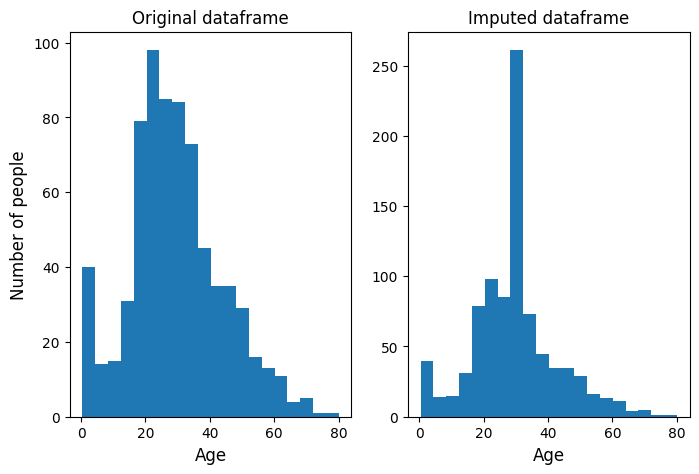

In [10]:
# Columns to drop in preparing the dataframes
drop_columns = ["Embarked", "Ticket", "Name", "PassengerId"]

new_train_df = prepare_dataframe(train_df, drop_columns)
new_test_df = prepare_dataframe(test_df, drop_columns)

#Plotting histograms of the feature variables
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize = (8,5))

# Create histograms
ax0.hist(train_df["Age"], bins=20);
ax1.hist(new_train_df["Age"], bins=20);

# Set labels
ax0.set_xlabel('Age', fontsize = 12)
ax0.set_ylabel('Number of people', fontsize = 12)
ax1.set_xlabel('Age', fontsize = 12)
ax0.set_title('Original dataframe')
ax1.set_title('Imputed dataframe')

print(new_train_df["Age"].isna().sum())
print(train_df["Age"].isna().sum())

In [11]:
# Quick fitting of the data
from sklearn.metrics import accuracy_score

# Setup the random seed
np.random.seed(42)

# Prepare dataframes
new_train_df = prepare_dataframe(train_df, drop_columns)
new_test_df = prepare_dataframe(test_df, drop_columns)

# First RandomForestClassifier 

# Split up into feature variables and target variables
x_train = new_train_df.drop(["Survived"], axis=1)
y_train = new_train_df["Survived"]
x_test = new_test_df

# Import randomforestclassifier
from sklearn.ensemble import RandomForestClassifier

# Instantiate the classifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(x_train, y_train)

# Predictions of the training data
y_preds = clf.predict(x_train)

print(accuracy_score(y_preds, y_train))

0.9865319865319865


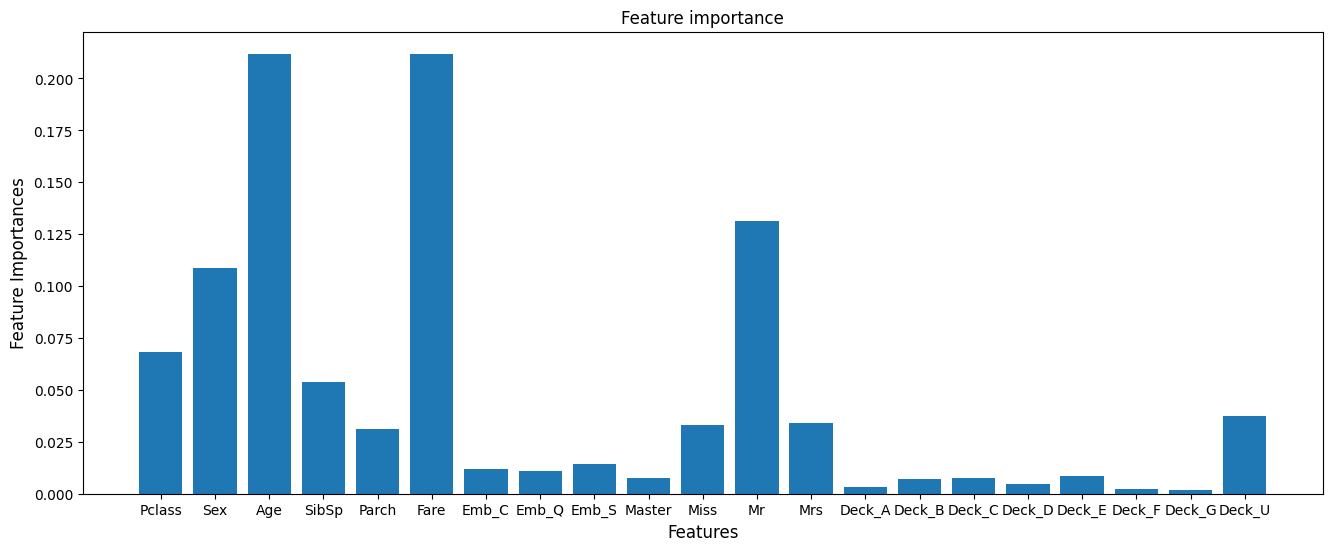

In [12]:
# Gives the importance of different features of the model
importance = clf.feature_importances_

# Shortened columns to appear on one plot
columns = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Emb_C',
       'Emb_Q', 'Emb_S', 'Master', 'Miss', 'Mr',
       'Mrs', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F',
       'Deck_G', 'Deck_U']

# The importance of the different feautures according to the model
importance_dictionary = {columns[i] : importance[i] for i in range(len(importance)) }
importance

keys = importance_dictionary.keys()
values = importance_dictionary.values()

# Plotting the feature importance
plt.figure(figsize=(16, 6))
plt.bar(keys, values)
plt.xlabel('Features', size=12)
plt.ylabel('Feature Importances', size=12)
plt.title('Feature importance')
plt.show()

In [23]:
original_columns = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Emb_C',
       'Emb_Q', 'Emb_S', 'Master', 'Miss', 'Mr',
       'Mrs', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F',
       'Deck_G', 'Deck_U']

In [24]:
# Import important modules
from  sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.base import clone

# Setup Random Seed
np.random.seed(42)

# Random Forest model, not including all the features below
drop_columns_cabin = ["Embarked", "Ticket", "Name", "PassengerId", 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D',
       'Deck_E', 'Deck_F', 'Deck_G', 'Deck_U']

# Print which columns we are including 
print(set(original_columns)-set(drop_columns_cabin))

# Grid of hyperparameters to sample from
grid = {
    'n_estimators': [100, 500, 1000, 2000],
    'max_depth': [None, 10, 20, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt'],
    'bootstrap': [True, False]
}
 

# Setup the random seed
np.random.seed(42)

# Creating dataframes discluding the cabins and titles 
x_train_cabin = prepare_dataframe(train_df, drop_columns_cabin).drop(["Survived"], axis=1)
y_train = new_train_df["Survived"]
x_test_cabin = prepare_dataframe(test_df, drop_columns_cabin)

# Instantiating Random forest classifier
clf = RandomForestClassifier(n_jobs = 1)

# Setting up randomised search of hyperparameters (considers 10 combinations) with cross validation
rs_clf = RandomizedSearchCV(estimator = clf, param_distributions=grid,
                       n_iter = 10, # number of models to try
                       cv = 5, # Setting the test set as the validation set
                       verbose =2 # Prints out logs as it is running
                       )
# Fit the classifier
rs_clf.fit(x_train_cabin, y_train);
# Best parameters of the 10 iterations
best_params_cabin = rs_clf.best_params_
# Dataframe of the results of each hyperparameter combination
cv_results_cabin = rs_clf.cv_results_

{'Age', 'SibSp', 'Emb_S', 'Fare', 'Sex', 'Pclass', 'Mr', 'Miss', 'Emb_C', 'Parch', 'Mrs', 'Master', 'Emb_Q'}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   1.4s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   1.4s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   1.4s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   1.4s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   1.4s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.2s
[CV] E

{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
0.8234850291883749


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.320719,0.013816,0.048372,0.000702,500,10,1,sqrt,10,True,"{'n_estimators': 500, 'min_samples_split': 10,...",0.793296,0.803371,0.876404,0.808989,0.853933,0.827199,0.032201,5
1,1.121299,0.010341,0.051178,0.000447,500,2,2,sqrt,None,False,"{'n_estimators': 500, 'min_samples_split': 2, ...",0.798883,0.803371,0.859551,0.792135,0.831461,0.817080,0.025107,8
2,0.235387,0.002754,0.013305,0.000339,100,5,1,sqrt,40,False,"{'n_estimators': 100, 'min_samples_split': 5, ...",0.770950,0.792135,0.837079,0.792135,0.831461,0.804752,0.025375,10
3,2.713009,0.037966,0.095613,0.001229,1000,5,1,sqrt,10,True,"{'n_estimators': 1000, 'min_samples_split': 5,...",0.810056,0.808989,0.865169,0.803371,0.859551,0.829427,0.027044,3
4,1.091369,0.014143,0.049828,0.000700,500,2,1,sqrt,10,False,"{'n_estimators': 500, 'min_samples_split': 2, ...",0.798883,0.797753,0.831461,0.797753,0.859551,0.817080,0.024855,8
5,1.342090,0.012028,0.049087,0.000542,500,10,1,sqrt,None,True,"{'n_estimators': 500, 'min_samples_split': 10,...",0.798883,0.797753,0.870787,0.808989,0.853933,0.826069,0.030360,6
6,2.630769,0.012129,0.092639,0.001199,1000,10,1,sqrt,10,True,"{'n_estimators': 1000, 'min_samples_split': 10...",0.798883,0.808989,0.882022,0.803371,0.853933,0.829439,0.032852,2
7,0.228511,0.013624,0.013480,0.001418,100,5,4,sqrt,None,False,"{'n_estimators': 100, 'min_samples_split': 5, ...",0.804469,0.803371,0.876404,0.814607,0.853933,0.830557,0.029402,1
8,1.360079,0.016506,0.051006,0.001839,500,5,1,sqrt,20,True,"{'n_estimators': 500, 'min_samples_split': 5, ...",0.815642,0.803371,0.876404,0.797753,0.853933,0.829421,0.030593,4
9,4.281089,0.021047,0.185660,0.000690,2000,2,2,sqrt,10,False,"{'n_estimators': 2000, 'min_samples_split': 2,...",0.793296,0.797753,0.859551,0.808989,0.859551,0.823828,0.029613,7


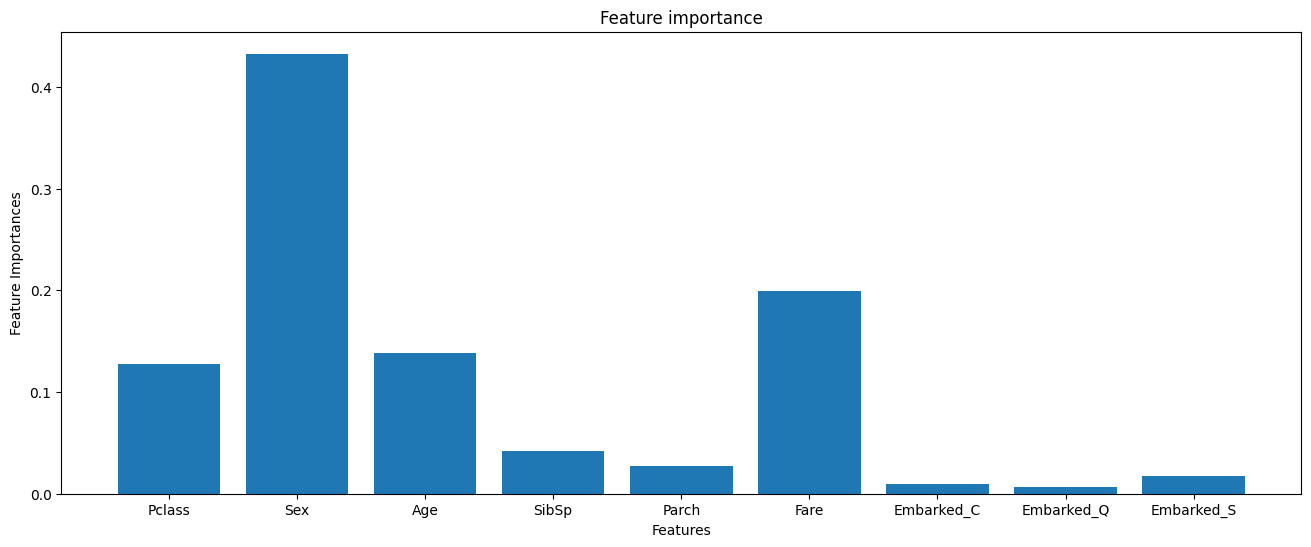

In [26]:
# Results of the cross validation 
pd.set_option('display.min_rows', 20) 
pd.set_option('display.max_rows', 20) 

# The best performing parameter, and the mean score of the 10 combinations
print(best_params_cabin)
print(cv_results_cabin["mean_test_score"].mean())

# Results of the 10 iterations
cv_results_cabin_df = pd.DataFrame(cv_results_cabin)
display(cv_results_cabin_df)

# Feature importances according to the classifier
importance = rs_clf.best_estimator_.feature_importances_
importance_dictionary = {x_train_cabin.columns[i] : importance[i] for i in range(len(importance)) }

keys = importance_dictionary.keys()
values = importance_dictionary.values()

# Plot the feature importance
plt.figure(figsize=(16, 6))
plt.bar(keys, values)
plt.xlabel('Features')
plt.ylabel('Feature Importances')
plt.title('Feature importance')
plt.show()

In [27]:
# Setup the random seed
np.random.seed(42)

# Random forest model not discluding all the features below
drop_columns_titles = ["Embarked", "Ticket", "Name", "PassengerId", 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', \
       'Deck_E', 'Deck_F', 'Deck_G', 'Deck_U']

# Print which columns we are including 
print(set(original_columns)-set(drop_columns_titles))

# Grid of hyperparameters to sample from
grid = {
    'n_estimators': [100, 500, 1000, 2000],
    'max_depth': [None, 10, 20, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt'],
    'bootstrap': [True, False]
}
 
# Creating dataframes discluding the titles
x_train_titles = prepare_dataframe(train_df, drop_columns_titles).drop(["Survived"], axis=1)
y_train = new_train_df["Survived"]
x_test_titles = prepare_dataframe(test_df, drop_columns_titles)

# Instantiating the Random Forest Classifier
clf = RandomForestClassifier(n_jobs = 1)

# Setting up randomised search of hyperparameters (considers 10 combinations) with cross validation
rs_clf_titles = RandomizedSearchCV(estimator = clf, param_distributions=grid,
                       n_iter = 10, # number of models to try
                       cv = 5, # Setting the test set as the validation set
                       verbose =2 # Prints out information as it is running
                       )
# Fit the classifier
rs_clf_titles.fit(x_train_titles, y_train);
# Best parameters of the 10 iterations
best_params_titles = rs_clf_titles.best_params_
# Dataframe of the results of each hyperparameter combination
cv_results_titles = rs_clf_titles.cv_results_

{'Age', 'SibSp', 'Emb_S', 'Fare', 'Sex', 'Pclass', 'Mr', 'Miss', 'Emb_C', 'Parch', 'Mrs', 'Master', 'Emb_Q'}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   1.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   1.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   1.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   1.4s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   1.3s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] E

{'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}
0.8243625635553326


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.295154,0.005262,0.048445,0.000772,500,10,1,sqrt,10,True,"{'n_estimators': 500, 'min_samples_split': 10,...",0.832402,0.786517,0.859551,0.803371,0.859551,0.828278,0.029453,3
1,1.098914,0.029487,0.051842,0.000931,500,2,2,sqrt,None,False,"{'n_estimators': 500, 'min_samples_split': 2, ...",0.821229,0.792135,0.870787,0.775281,0.831461,0.818178,0.033081,9
2,0.225461,0.003264,0.013028,0.000186,100,5,1,sqrt,40,False,"{'n_estimators': 100, 'min_samples_split': 5, ...",0.798883,0.797753,0.853933,0.780899,0.825843,0.811462,0.025655,10
3,2.610639,0.017368,0.093526,0.004488,1000,5,1,sqrt,10,True,"{'n_estimators': 1000, 'min_samples_split': 5,...",0.810056,0.797753,0.870787,0.803371,0.848315,0.826056,0.028524,5
4,1.055219,0.011579,0.050293,0.001392,500,2,1,sqrt,10,False,"{'n_estimators': 500, 'min_samples_split': 2, ...",0.821229,0.797753,0.865169,0.797753,0.842697,0.824920,0.026175,7
5,1.310043,0.006761,0.049166,0.001445,500,10,1,sqrt,None,True,"{'n_estimators': 500, 'min_samples_split': 10,...",0.826816,0.786517,0.870787,0.803371,0.859551,0.829408,0.032078,2
6,2.588201,0.022600,0.093641,0.001594,1000,10,1,sqrt,10,True,"{'n_estimators': 1000, 'min_samples_split': 10...",0.821229,0.803371,0.859551,0.803371,0.859551,0.829414,0.025456,1
7,0.209797,0.002705,0.012145,0.000353,100,5,4,sqrt,None,False,"{'n_estimators': 100, 'min_samples_split': 5, ...",0.810056,0.780899,0.876404,0.808989,0.859551,0.827180,0.035319,4
8,1.330452,0.003779,0.049623,0.000740,500,5,1,sqrt,20,True,"{'n_estimators': 500, 'min_samples_split': 5, ...",0.810056,0.797753,0.859551,0.797753,0.848315,0.822685,0.026148,8
9,4.146541,0.047577,0.190531,0.003870,2000,2,2,sqrt,10,False,"{'n_estimators': 2000, 'min_samples_split': 2,...",0.821229,0.786517,0.870787,0.803371,0.848315,0.826044,0.030323,6


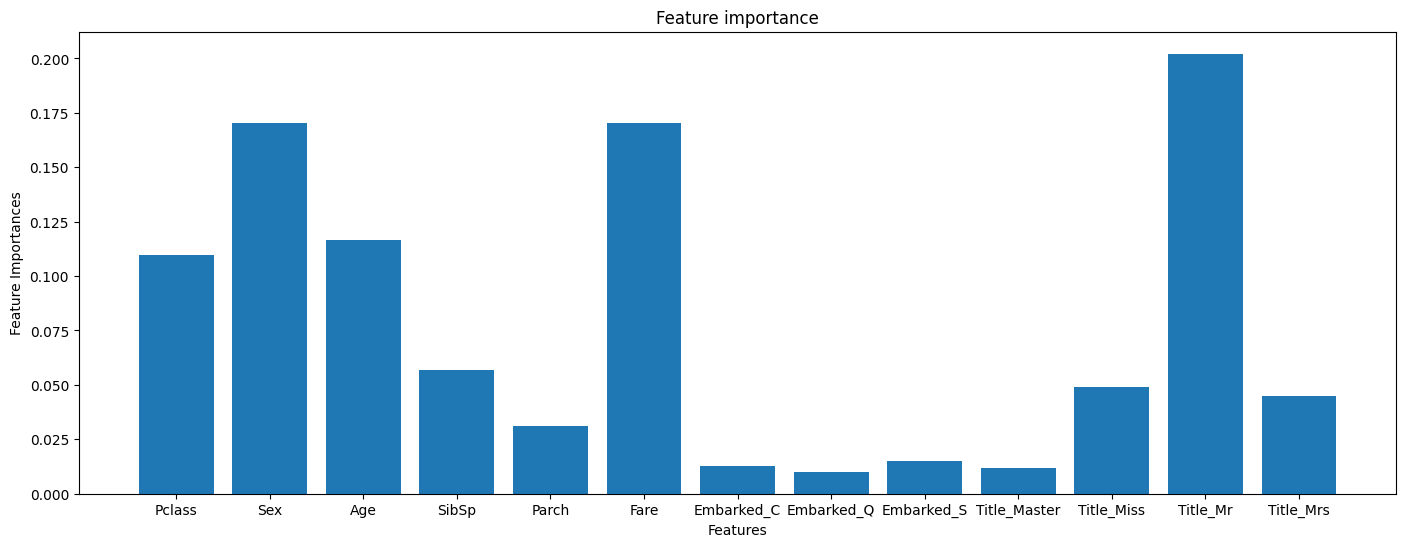

In [29]:
# Results of the cross validation 
print(best_params_titles)
print(cv_results_titles["mean_test_score"].mean())

# Dataframe results of the 10 iterations
cv_results_titles_df = pd.DataFrame(cv_results_titles)
display(cv_results_titles_df)


# Feature importances according to the classifier
importance = rs_clf_titles.best_estimator_.feature_importances_
importance_dictionary = {x_train_titles.columns[i] : importance[i] for i in range(len(importance)) }

keys = importance_dictionary.keys()
values = importance_dictionary.values()

# Plot the feature importance
plt.figure(figsize=(17, 6))
plt.bar(keys, values)
plt.xlabel('Features')
plt.ylabel('Feature Importances')
plt.title('Feature importance')
plt.show()

In [30]:
# Setup the random seed 
np.random.seed(42)

# # Random forest model discluding all the features below
drop_columns_decks = ["Embarked", "Ticket", "Name", "PassengerId"]

# Print which columns we are including 
print(set(original_columns)-set(drop_columns_decks))

# Grid of hyperparameters to sample from
grid = {
    'n_estimators': [100, 500, 1000, 2000],
    'max_depth': [None, 10, 20, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt'],
    'bootstrap': [True, False]
}

# Creating dataframes discluding the titles
x_train_decks = prepare_dataframe(train_df, drop_columns_decks).drop(["Survived"], axis=1)
y_train = new_train_df["Survived"]
x_test_decks = prepare_dataframe(test_df, drop_columns_decks)

# Instantiating the Random Forest Classifier
clf = RandomForestClassifier(n_jobs = 1)

# Setting up randomised search of hyperparameters (considers 10 combinations) with cross validation
rs_clf_decks = RandomizedSearchCV(estimator = clf, param_distributions=grid,
                       n_iter = 10, # number of models to try
                       cv = 5, # Setting the test set as the validation set
                       verbose =2 # Prints out information as it is running
                       )
# Fit the classifier
rs_clf_decks.fit(x_train_decks, y_train);
# Best parameters of the 10 iterations
best_params_decks = rs_clf_decks.best_params_
# Dataframe of the results of each hyperparameter combination
cv_results_decks = rs_clf_decks.cv_results_

{'Age', 'Deck_A', 'Deck_C', 'Deck_F', 'Fare', 'Deck_E', 'Sex', 'Miss', 'Emb_C', 'Mrs', 'Master', 'Emb_S', 'SibSp', 'Deck_U', 'Deck_G', 'Deck_D', 'Pclass', 'Mr', 'Emb_Q', 'Parch', 'Deck_B'}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   1.4s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   1.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   1.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   1.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   1.3s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_

{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
0.8258006402611262


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.304882,0.035457,0.048424,0.000438,500,10,1,sqrt,10,True,"{'n_estimators': 500, 'min_samples_split': 10,...",0.826816,0.786517,0.848315,0.808989,0.853933,0.824914,0.024985,8
1,1.077326,0.012765,0.050790,0.000569,500,2,2,sqrt,None,False,"{'n_estimators': 500, 'min_samples_split': 2, ...",0.860335,0.786517,0.853933,0.797753,0.837079,0.827123,0.029774,6
2,0.228641,0.002043,0.013407,0.000217,100,5,1,sqrt,40,False,"{'n_estimators': 100, 'min_samples_split': 5, ...",0.810056,0.775281,0.831461,0.775281,0.831461,0.804708,0.025266,10
3,2.597619,0.013197,0.092147,0.003618,1000,5,1,sqrt,10,True,"{'n_estimators': 1000, 'min_samples_split': 5,...",0.843575,0.808989,0.853933,0.797753,0.853933,0.831636,0.023655,2
4,1.057180,0.013220,0.049348,0.000424,500,2,1,sqrt,10,False,"{'n_estimators': 500, 'min_samples_split': 2, ...",0.843575,0.803371,0.853933,0.780899,0.848315,0.826018,0.028752,7
5,1.318550,0.011354,0.049541,0.001438,500,10,1,sqrt,None,True,"{'n_estimators': 500, 'min_samples_split': 10,...",0.837989,0.792135,0.865169,0.803371,0.853933,0.830519,0.028337,3
6,2.550639,0.016930,0.095771,0.004125,1000,10,1,sqrt,10,True,"{'n_estimators': 1000, 'min_samples_split': 10...",0.826816,0.792135,0.859551,0.808989,0.848315,0.827161,0.024713,5
7,0.207566,0.002056,0.012675,0.000173,100,5,4,sqrt,None,False,"{'n_estimators': 100, 'min_samples_split': 5, ...",0.843575,0.797753,0.859551,0.808989,0.859551,0.833884,0.025833,1
8,1.337157,0.015685,0.050569,0.001462,500,5,1,sqrt,20,True,"{'n_estimators': 500, 'min_samples_split': 5, ...",0.837989,0.792135,0.842697,0.792135,0.848315,0.822654,0.025132,9
9,4.083561,0.022096,0.185292,0.004036,2000,2,2,sqrt,10,False,"{'n_estimators': 2000, 'min_samples_split': 2,...",0.843575,0.792135,0.853933,0.808989,0.848315,0.829389,0.024355,4


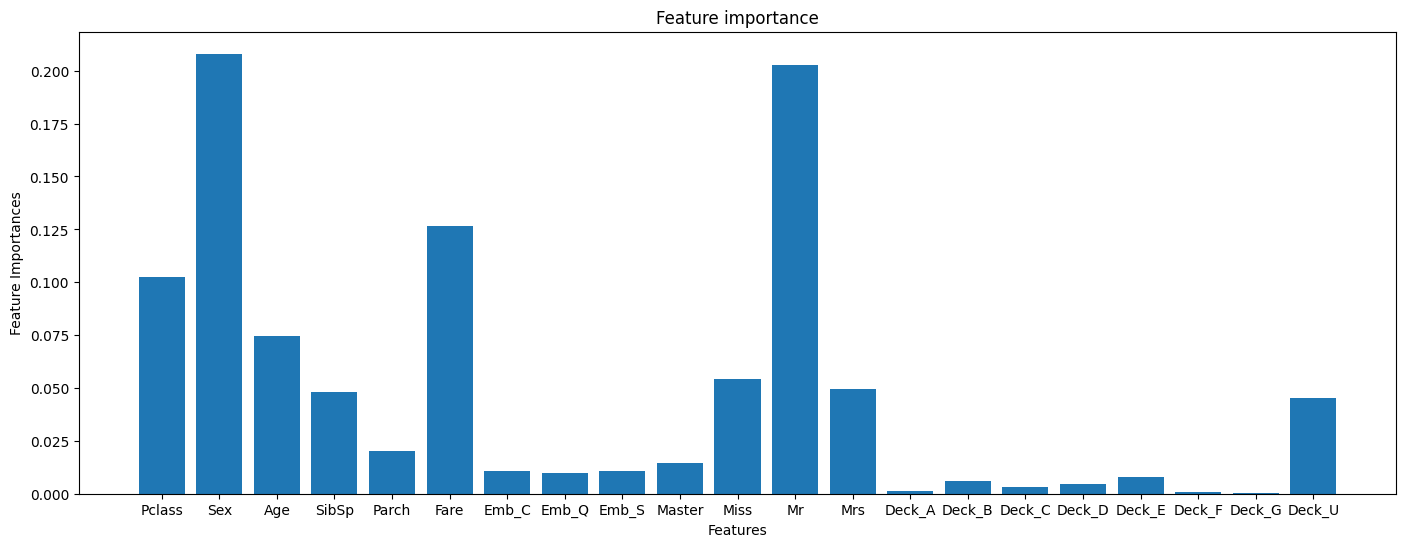

In [31]:
# Results of the cross validation
print(best_params_decks)
print(cv_results_decks["mean_test_score"].mean())

# Dataframe results of the 10 iterations
cv_results_decks_df = pd.DataFrame(cv_results_decks)
display(cv_results_decks_df)

importance = rs_clf_decks.best_estimator_.feature_importances_

# Custom columns to fit in the plot (previous labels too long)
columns = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Emb_C',
       'Emb_Q', 'Emb_S', 'Master', 'Miss', 'Mr',
       'Mrs', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F',
       'Deck_G', 'Deck_U']

# Feature importances according to the classifier
importance_dictionary = {columns[i] : importance[i] for i in range(len(importance)) }
importance

keys = importance_dictionary.keys()
values = importance_dictionary.values()

# Plot the feature importance
plt.figure(figsize=(17, 6))
plt.bar(keys, values)
plt.xlabel('Features')
plt.ylabel('Feature Importances')
plt.title('Feature importance')
plt.show()

In [32]:
# Import important functions
from  sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve

# Setup random seed
np.random.seed(42)

# Function to divide a dataframe into validation and training sets with cross validation (k-folds). Returns the desired fold  
def cross_val_index(k_folds, x_dataframe, y_dataframe, fold_number):
    index = round(len(x_dataframe)/k_folds)
    start_index, end_index = [], []
    for i in range(k_folds):
                start_index.append(i * index)
                end_index.append((i + 1) * index if i < k_folds - 1 else len(x_dataframe))
    print(start_index[fold_number-1], end_index[fold_number-1])
    X_train = pd.concat([x_dataframe[:start_index[fold_number-1]], x_dataframe[end_index[fold_number-1]:]])
    y_train = pd.concat([y_dataframe[:start_index[fold_number-1]], y_dataframe[end_index[fold_number-1]:]])
    X_valid = x_dataframe[start_index[fold_number-1]:end_index[fold_number-1]]
    y_valid = y_dataframe[start_index[fold_number-1]:end_index[fold_number-1]]
    print(len(X_valid), len(y_valid))
    
    return X_train, y_train, X_valid, y_valid



drop_columns = ["Embarked", "Ticket", "Name", "PassengerId"]

# Setting up validation dataframes
new_train_df = prepare_dataframe(train_df, drop_columns)
x_train = new_train_df.drop(["Survived"], axis=1)
y_train = new_train_df["Survived"]

cross_val_dataframes = cross_val_index(5, x_train, y_train, 5)

# Calculating the probabilities of prediction with the best RandomForestClassifier
best_clf = RandomForestClassifier( **{'n_estimators': 2000, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': False})
best_clf.fit(cross_val_dataframes[0], cross_val_dataframes[1])
best_y_valid_preds = best_clf.predict(cross_val_dataframes[2])
best_y_valids_proba = best_clf.predict_proba(cross_val_dataframes[2])
best_y_valids_proba_pos = best_y_valids_proba[:, 1]
print(accuracy_score(best_y_valid_preds, cross_val_dataframes[3]))

# Calculating the probabilities of prediction with the worst RandomForestClassifier
worst_clf = RandomForestClassifier( **{'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': False})
worst_clf.fit(cross_val_dataframes[0], cross_val_dataframes[1])
worst_y_valid_preds = worst_clf.predict(cross_val_dataframes[2])
worst_y_valids_proba = worst_clf.predict_proba(cross_val_dataframes[2])
worst_y_valids_proba_pos = worst_y_valids_proba[:, 1]
print(accuracy_score(worst_y_valid_preds, cross_val_dataframes[3]))

# Calculating the rates and thresholds for the two classifiers
best_fpr, best_tpr, best_thresholds = roc_curve(cross_val_dataframes[3].values, best_y_valids_proba_pos)
worst_fpr, worst_tpr, worst_thresholds = roc_curve(cross_val_dataframes[3].values, worst_y_valids_proba_pos)

712 891
179 179
0.8547486033519553
0.8212290502793296


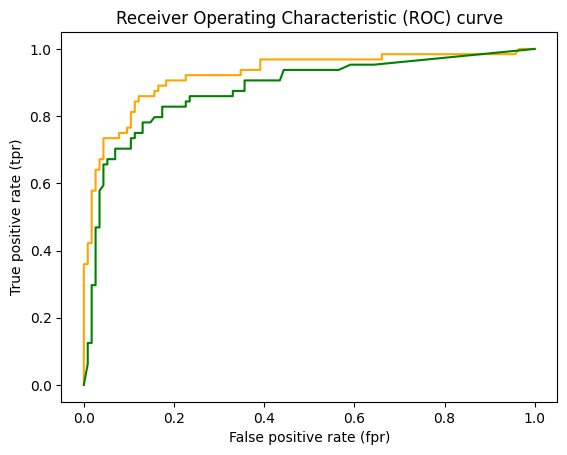

In [33]:
# Plotting the ROC curves fo rhte best and worst classifiers 
plt.plot(best_fpr, best_tpr, color='orange', label='ROC')
plt.plot(worst_fpr, worst_tpr, color='green', label='ROC')
plt.xlabel('False positive rate (fpr)')
plt.ylabel('True positive rate (tpr)')
plt.title('Receiver Operating Characteristic (ROC) curve')
plt.show()

In [93]:
# Submitting a prediction 

# Dropping only unnecessary columns
drop_columns = ["Embarked", "Ticket", "Name", "PassengerId"]

# Prepare dataframes
new_train_df = prepare_dataframe(train_df, drop_columns)
x_train = new_train_df.drop(["Survived"], axis=1)
y_train = new_train_df["Survived"]
x_test = prepare_dataframe(test_df, drop_columns)

# Instantiate Random Forest Classifier with best hyperparameters
best_clf = RandomForestClassifier( **{'n_estimators': 2000, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt',
                                      'max_depth': 40, 'bootstrap': False})
best_clf.fit(x_train, y_train)
best_y_preds = best_clf.predict(x_test)

# Fit the classifier and make predictions
clf.fit(x_train, y_train)
best_y_preds = clf.predict(x_test)

# Create a csv file with the predictions
output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': best_y_preds})
print(output)
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         0
5            897         0
6            898         0
7            899         0
8            900         1
9            901         0
..           ...       ...
408         1300         1
409         1301         1
410         1302         1
411         1303         1
412         1304         0
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         1

[418 rows x 2 columns]
Your submission was successfully saved!


In [35]:
# Quick fitting of the data for a logistic regression model 

new_train_df = prepare_dataframe(train_df, drop_columns)
new_test_df = prepare_dataframe(test_df, drop_columns)

# First RandomForestClassifier 

# Setup the random seed
np.random.seed(42)

# Split up into feature variables and target variables
x_train = new_train_df.drop(["Survived"], axis=1)
y_train = new_train_df["Survived"]
x_test = new_test_df

# Import randomforestclassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Instantiate the classifier
log_clf = LogisticRegression(max_iter=1000)
log_clf.fit(x_train, y_train)

y_preds = clf.predict(x_train)

print(accuracy_score(y_preds, y_train))

0.9865319865319865


In [36]:
# Submitting the basic logistic regression classifier 
log_y_preds = log_clf.predict(x_test)

output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': log_y_preds})
print(output)
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

     PassengerId  Survived
0            892         0
1            893         1
2            894         0
3            895         0
4            896         1
5            897         0
6            898         1
7            899         0
8            900         1
9            901         0
..           ...       ...
408         1300         1
409         1301         1
410         1302         1
411         1303         1
412         1304         1
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         1

[418 rows x 2 columns]
Your submission was successfully saved!


In [37]:
# Setup random seed 
np.random.seed(42)

# Discluding these features
drop_columns_decks = ["Embarked", "Ticket", "Name", "PassengerId"]

# Logistic regression hyperparameters to sample from 
log_grid = {
    'penalty': ['l1', 'l2'],
    'C': [1, 5, 10, 100],
    'solver': ['liblinear'],
    'class_weight': [None, 'balanced'],
    'max_iter': [2000, 4000],
    'tol': [0.0001, 0.001, 0.01],
    'multi_class': ['ovr']
}

# Creating dataframes
x_train_decks = prepare_dataframe(train_df, drop_columns_decks).drop(["Survived"], axis=1)
y_train = new_train_df["Survived"]
x_test_decks = prepare_dataframe(test_df, drop_columns_decks)

# Instantiating the Logistic regression classifier
log_clf = LogisticRegression()

# Setting up randomised search of hyperparameters (considers 10 combinations) with cross validation
rs_log_clf_decks = RandomizedSearchCV(estimator = log_clf, param_distributions=log_grid,
                       n_iter = 10, # number of models to try
                       cv = 5, # Setting the test set as the validation set
                       verbose =2 # Prints out information as it is running
                       )
# Fit the classifier
rs_log_clf_decks.fit(x_train_decks, y_train);
# Best parameters of the 10 iterations
log_best_params_decks = rs_log_clf_decks.best_params_
# Dataframe of the results of each hyperparameter combination
log_cv_results_decks = rs_log_clf_decks.cv_results_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END C=100, class_weight=None, max_iter=4000, multi_class=ovr, penalty=l1, solver=liblinear, tol=0.01; total time=   0.0s
[CV] END C=100, class_weight=None, max_iter=4000, multi_class=ovr, penalty=l1, solver=liblinear, tol=0.01; total time=   0.0s
[CV] END C=100, class_weight=None, max_iter=4000, multi_class=ovr, penalty=l1, solver=liblinear, tol=0.01; total time=   0.0s
[CV] END C=100, class_weight=None, max_iter=4000, multi_class=ovr, penalty=l1, solver=liblinear, tol=0.01; total time=   0.0s
[CV] END C=100, class_weight=None, max_iter=4000, multi_class=ovr, penalty=l1, solver=liblinear, tol=0.01; total time=   0.0s
[CV] END C=100, class_weight=None, max_iter=2000, multi_class=ovr, penalty=l2, solver=liblinear, tol=0.01; total time=   0.0s
[CV] END C=100, class_weight=None, max_iter=2000, multi_class=ovr, penalty=l2, solver=liblinear, tol=0.01; total time=   0.0s
[CV] END C=100, class_weight=None, max_iter=2000, multi_c

In [39]:
# Results of the cross validation 
print(log_best_params_decks)
print(log_cv_results_decks["mean_test_score"].mean())

# Dataframe results of the 10 iterations
log_cv_results_decks_df = pd.DataFrame(log_cv_results_decks)
display(log_cv_results_decks_df)

{'tol': 0.0001, 'solver': 'liblinear', 'penalty': 'l1', 'multi_class': 'ovr', 'max_iter': 2000, 'class_weight': None, 'C': 1}
0.8189655388864479


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tol,param_solver,param_penalty,param_multi_class,param_max_iter,param_class_weight,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.006484,0.000306,0.003057,0.000125,0.01,liblinear,l1,ovr,4000,None,100,"{'tol': 0.01, 'solver': 'liblinear', 'penalty'...",0.826816,0.814607,0.792135,0.820225,0.859551,0.822666,0.021821,3
1,0.008142,0.000325,0.003155,0.000065,0.01,liblinear,l2,ovr,2000,None,100,"{'tol': 0.01, 'solver': 'liblinear', 'penalty'...",0.832402,0.808989,0.786517,0.820225,0.853933,0.820413,0.022569,7
2,0.009157,0.001070,0.003050,0.000107,0.001,liblinear,l1,ovr,2000,None,100,"{'tol': 0.001, 'solver': 'liblinear', 'penalty...",0.826816,0.814607,0.797753,0.820225,0.853933,0.822666,0.018365,3
3,0.009294,0.000636,0.003304,0.000492,0.001,liblinear,l2,ovr,4000,balanced,100,"{'tol': 0.001, 'solver': 'liblinear', 'penalty...",0.804469,0.786517,0.792135,0.803371,0.853933,0.808085,0.023904,10
4,0.009916,0.000502,0.003079,0.000038,0.0001,liblinear,l2,ovr,4000,None,5,"{'tol': 0.0001, 'solver': 'liblinear', 'penalt...",0.826816,0.820225,0.792135,0.820225,0.853933,0.822666,0.019692,3
5,0.008641,0.000214,0.003006,0.000031,0.001,liblinear,l1,ovr,4000,None,100,"{'tol': 0.001, 'solver': 'liblinear', 'penalty...",0.826816,0.820225,0.797753,0.814607,0.853933,0.822666,0.018365,3
6,0.011241,0.000839,0.003196,0.000062,0.0001,liblinear,l2,ovr,4000,balanced,10,"{'tol': 0.0001, 'solver': 'liblinear', 'penalt...",0.804469,0.780899,0.792135,0.803371,0.859551,0.808085,0.027120,9
7,0.026746,0.011384,0.003263,0.000051,0.0001,liblinear,l1,ovr,4000,balanced,5,"{'tol': 0.0001, 'solver': 'liblinear', 'penalt...",0.798883,0.786517,0.797753,0.808989,0.865169,0.811462,0.027781,8
8,0.015312,0.004922,0.003316,0.000168,0.0001,liblinear,l1,ovr,2000,None,1,"{'tol': 0.0001, 'solver': 'liblinear', 'penalt...",0.832402,0.825843,0.803371,0.814607,0.853933,0.826031,0.017106,1
9,0.008475,0.000515,0.003247,0.000279,0.001,liblinear,l2,ovr,4000,None,1,"{'tol': 0.001, 'solver': 'liblinear', 'penalty...",0.826816,0.820225,0.803371,0.820225,0.853933,0.824914,0.016455,2


In [40]:
#Submitting predictions for the logistic regression model 
drop_columns = ["Embarked", "Ticket", "Name", "PassengerId"]

# Creating the dataframes
new_train_df = prepare_dataframe(train_df, drop_columns)
x_train = new_train_df.drop(["Survived"], axis=1)
y_train = new_train_df["Survived"]
x_test = prepare_dataframe(test_df, drop_columns)

# Picking the best hyperparameters and fitting the model
best_log_clf = LogisticRegression( **{'tol': 0.0001, 'solver': 'liblinear', 'penalty': 'l1', 'multi_class': 'ovr', 'max_iter': 2000, 'class_weight': None, 'C': 1})
best_log_clf.fit(x_train, y_train)
best_log_y_preds = best_log_clf.predict(x_test)

# Creating a csv file with the predictions 
output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': best_log_y_preds})
print(output)
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

     PassengerId  Survived
0            892         0
1            893         1
2            894         0
3            895         0
4            896         1
5            897         0
6            898         1
7            899         0
8            900         1
9            901         0
..           ...       ...
408         1300         1
409         1301         1
410         1302         1
411         1303         1
412         1304         1
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         1

[418 rows x 2 columns]
Your submission was successfully saved!
